In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import textwrap

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patheffects as pe

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, plot_terrain

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
# Set up paths
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load continental divide shapefile
fp = path_to_data + 'downloads/continental_divide_shapefile/pw312bv3382.shp'
divide = gpd.read_file(fp, crs="ESPG:4326")

## load HU2 shapefile for regions 10, 11, 13, 14
region_lst = [10, 11, 13, 14]
WBD_lst = []
for i, region in enumerate(region_lst):
    fp = path_to_data + 'downloads/WBD_HU2_{0}/Shape/WBDHU2.shp'.format(region)
    WBD = gpd.read_file(fp, crs="ESPG:3857")
    WBD_lst.append(WBD)

## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:3857") # have to manually set the projection


In [4]:
HUC8_ID_lst = ['14050001', '13010001', '10190002', '11020001']
HUC8_lbl_lst = ['Upper Yampa', 'Rio Grande Headwaters', 'Upper South Platte', 'Arkansas Headwaters']
lbl_align = ['right', 'right', 'left', 'left']
polys_lst = []
for i, HUC8_ID in enumerate(HUC8_ID_lst):
    idx = (polys.HUC8 == str(HUC8_ID_lst[i]))
    tmp =  polys[idx]
    polys_lst.append(tmp)

In [5]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
ext1 = [-111., -100., 35.5, 42.5] # extent of CO
ext = [-129., -90., 22, 50] ## extent of interior west

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(-120.,-80+tx,tx)
dy = np.arange(20,50+ty,ty)

lbl_dict = {'Upper Colorado': (-109.5, 40.),
            'Arkansas': (-102., 36.5),
            'Rio Grande': (-106., 33.5),
            'Missouri': (-103., 41.5)
    }

lbl_dict2 = {'Gulf of Mexico': (-94., 26.),
            'Gulf of California': (-113, 30),
            'Baja Peninsula': (-113., 26),
            'Great Plains': (-95.5, 37),
             'Four Corners': (-109., 36.5),
             'Pacific Northwest': (-122., 45.)
    }

lbl_dict3 = {'Upper Yampa': (-107.5, 41.25), 
             'Rio Grande Headwaters': (-106.92835478819255, 36.55), 
             'Upper South Platte': (-103.75, 40), 
             'Arkansas Headwaters': (-104., 37.5)
}

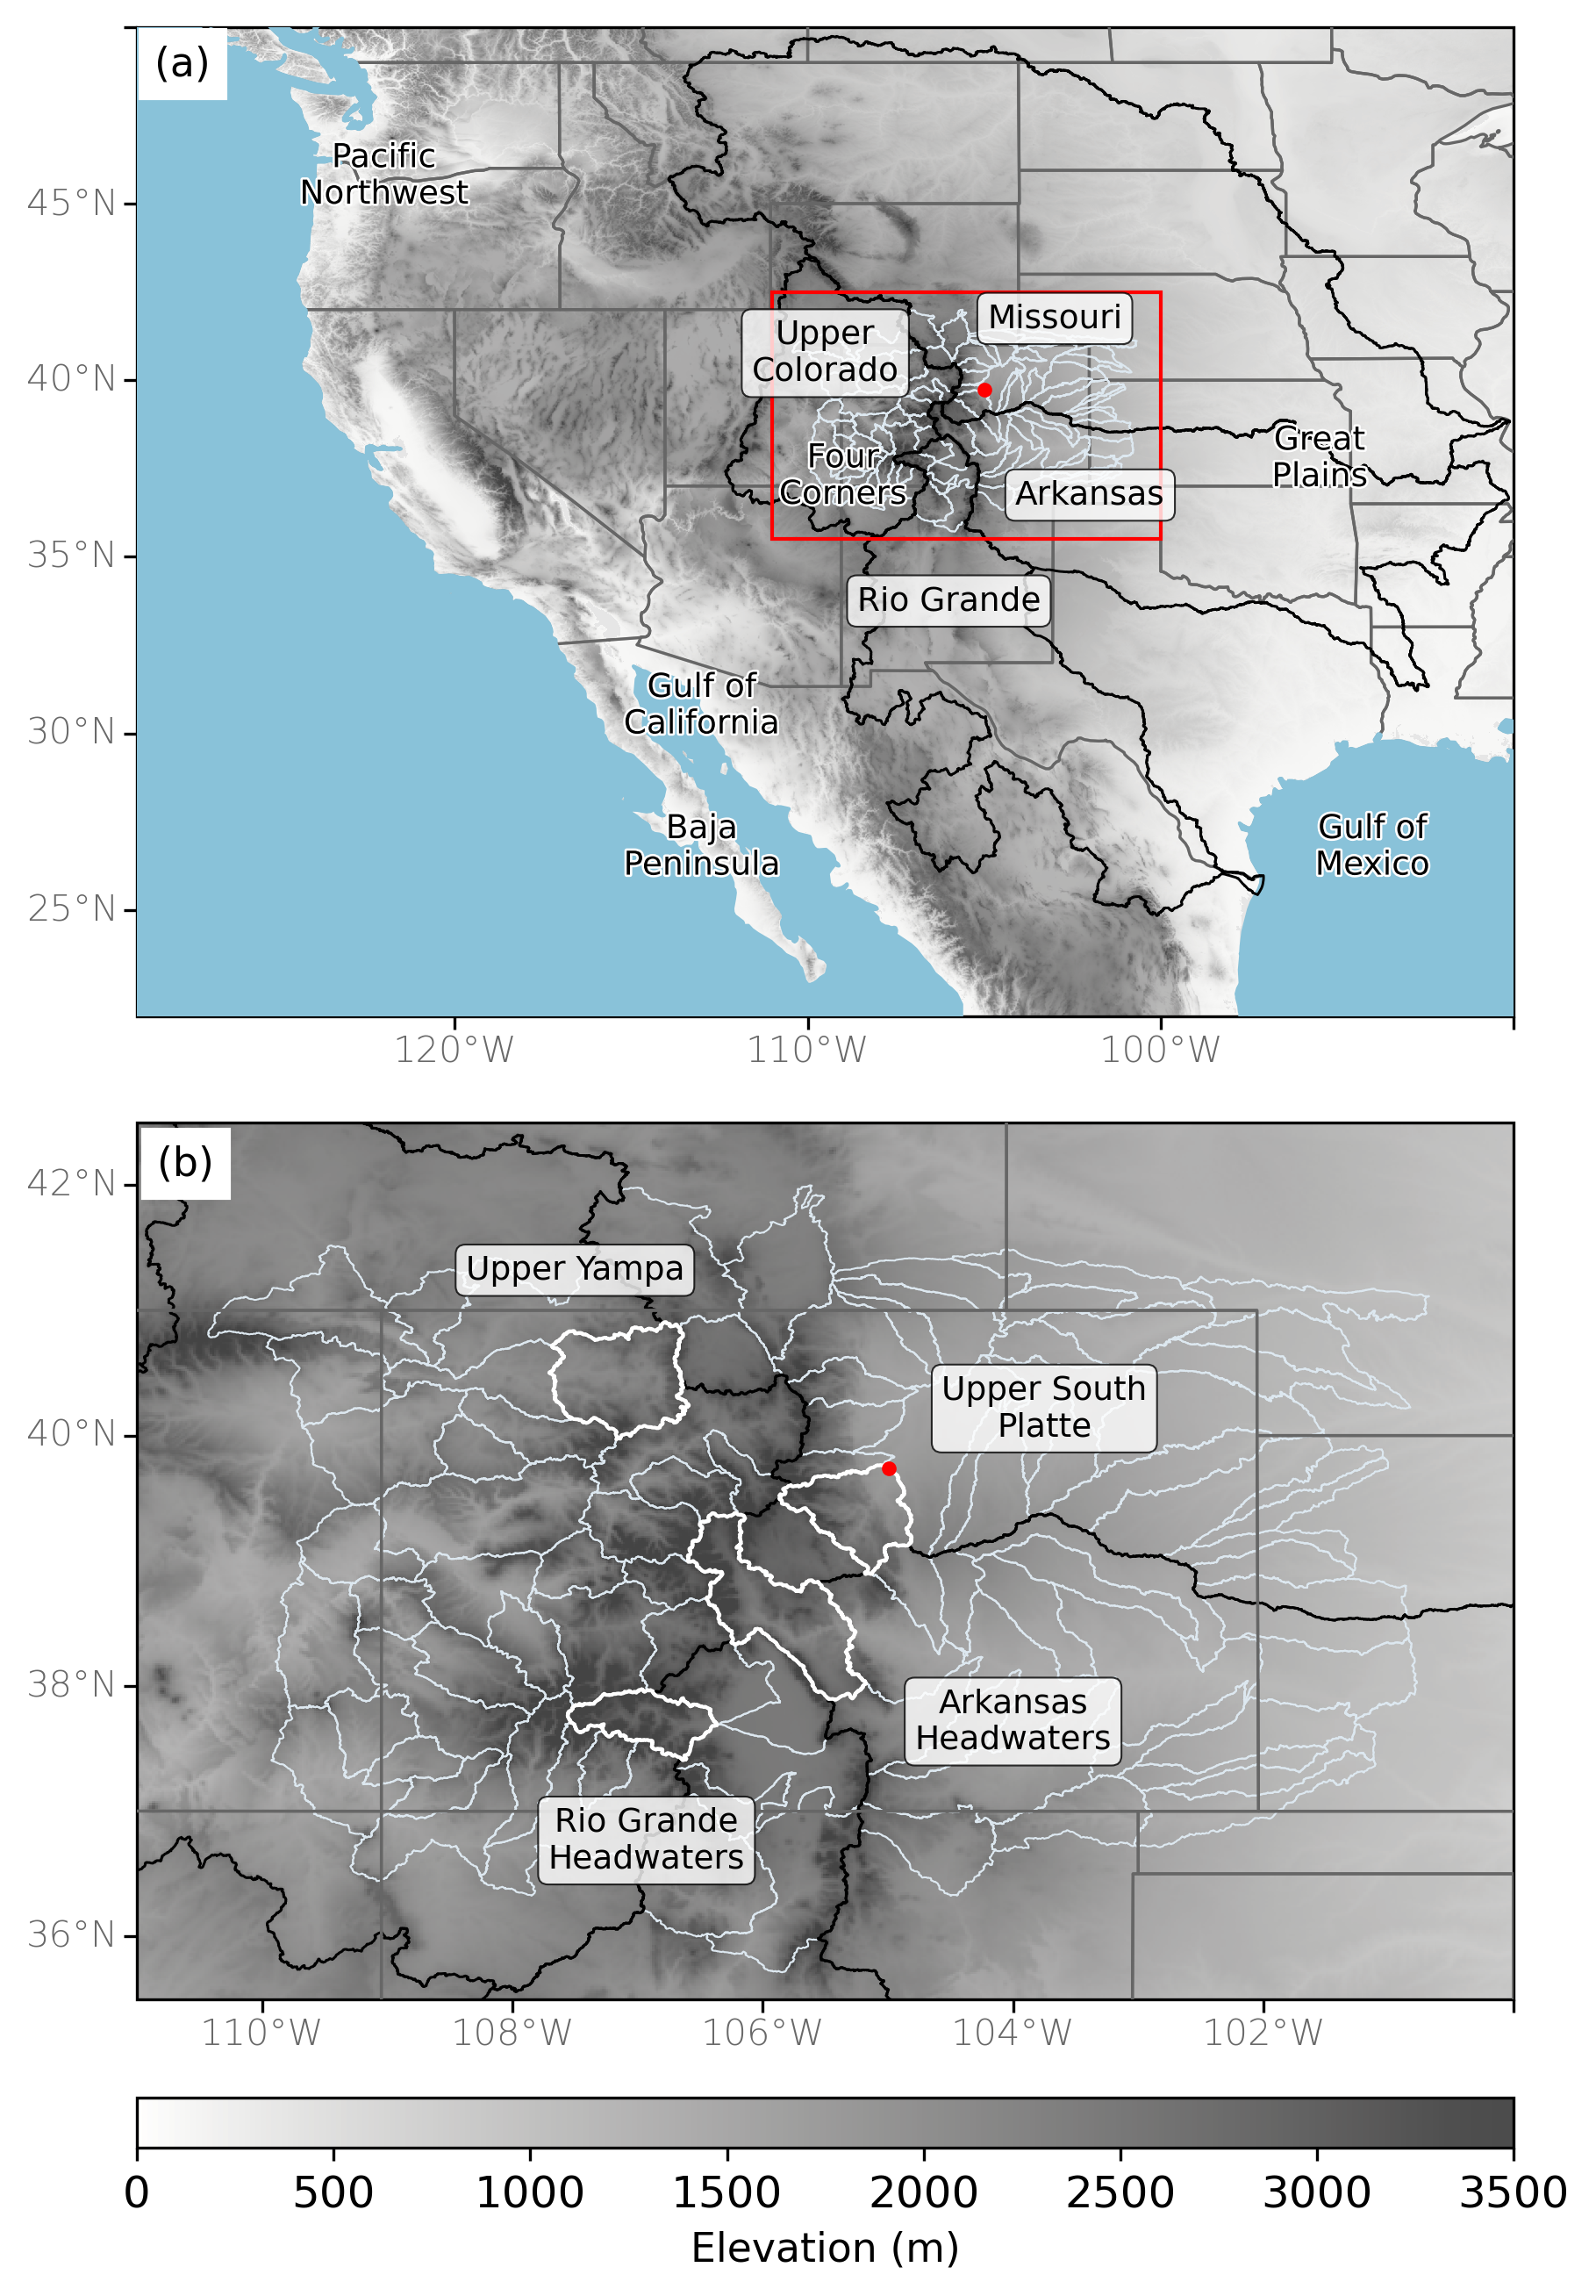

In [6]:
# Create figure
fig = plt.figure(figsize=(6.75, 10.5))
fig.dpi = 300
fname = path_to_figs + 'elevation_map_with_inset'
fmt = 'png'

nrows = 3
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.05], width_ratios = [1], wspace=0.02, hspace=0.05)
## use gs[rows index, columns index] to access grids


#### Add topography map with labels
ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=True, 
                      right_lats=False, bottom_lons=True, mask_ocean=False, coastline=False)

## topo with gray shading
ax, cs = plot_terrain(ax, ext, vmax=3500, greyscale=True, zorder=2)


## add in region watershed shape
for j, WBD in enumerate(WBD_lst):
    WBD.crs = 'epsg:3857'
    WBD.plot(ax=ax, edgecolor='k', color='None', linewidth=0.7, zorder=99)
# ## add in subbasins
polys.crs = 'epsg:3857'
polys.plot(ax=ax, edgecolor='#dde8f0', color='None', linewidth=0.5, zorder=98)

ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8, zorder=4)
ax.add_feature(cfeature.OCEAN, edgecolor='#89C2D9', zorder=6, facecolor='#89C2D9') # mask ocean
# Plot Location of pts
ax.plot(-104.9903, 39.7392, 'ro', markersize=3, transform=datacrs, zorder=201)



## Plot the labels
# need this to fix annotate transform
transform = datacrs._as_mpl_transform(ax)
style = {'size': 9, 'color': 'black', 'fontweight': 'normal'}
for lbl in lbl_dict:
    xy = lbl_dict[lbl]
    ax.annotate(textwrap.fill(lbl, 11), # this is the text
                xy, # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,0), # distance from text to points (x,y)
                ha='center', # horizontal alignment can be left, right or center
                xycoords=transform,
                zorder=200,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=0.5, alpha=0.8),
                **style)

for lbl in lbl_dict2:
    xy = lbl_dict2[lbl]
    ax.annotate(textwrap.fill(lbl, 11), # this is the text
               xy, # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,0), # distance from text to points (x,y)
                ha='center', # horizontal alignment can be left, right or center
                xycoords=transform,
                zorder=200,
                path_effects=[pe.withStroke(linewidth=1.25, foreground="white")],
                **style)

ax.add_patch(mpatches.Rectangle(xy=[ext1[0], ext1[2]], width=ext1[1]-ext1[0], height=ext1[3]-ext1[2],
                                fill=False,
                                edgecolor='r',
                                linewidth=1.0,
                                transform=datacrs,
                                zorder=100))

for spine in ax.spines.values():
    spine.set_edgecolor('k')

titlestring = '(a)'
ax.text(0.013, 0.9825, titlestring, ha='left', va='top', transform=ax.transAxes, 
        fontsize=11., backgroundcolor='white', zorder=500)

# Add color bar
cbax = plt.subplot(gs[-1,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cs, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('Elevation (m)', fontsize=11)
cb.ax.tick_params(labelsize=12)

### Add inset map  [left, bottom, width, height]

# Set tick/grid locations
tx = 2
ty = 2
dx = np.arange(-110.,-80+tx,tx)
dy = np.arange(20,50+ty,ty)

axins = fig.add_subplot(gs[1, 0], projection=mapcrs)
axins = draw_basemap(axins, extent=ext1, xticks=dx, yticks=dy,left_lats=True, 
                      right_lats=False, bottom_lons=True, mask_ocean=False, coastline=False)

# axins.add_patch(mpatches.Rectangle(xy=[ext1[0], ext1[2]], width=ext1[1]-ext1[0], height=ext1[3]-ext1[2],
#                                 fill=False,
#                                 edgecolor='r',
#                                 linewidth=1.0,
#                                 transform=datacrs,
#                                 zorder=100))

# topo with grey shade map
axins, cs = plot_terrain(axins, ext1, vmax=3500, greyscale=True, zorder=2)
axins.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8, zorder=199)

## add in region watershed shape
for j, WBD in enumerate(WBD_lst):
    WBD.crs = 'epsg:3857'
    WBD.plot(ax=axins, edgecolor='k', color='None', linewidth=0.7, zorder=99)
    ## add in four focus watersheds
    polys_lst[j].crs = 'epsg:3857'
    polys_lst[j].plot(ax=axins, edgecolor='white', color='None', zorder=100)
# ## add in subbasins
polys.crs = 'epsg:3857'
polys.plot(ax=axins, edgecolor='#dde8f0', color='None', linewidth=0.5, zorder=98)

# zip joins x and y coordinates in pairs
transform = datacrs._as_mpl_transform(axins)
style = {'size': 9, 'color': 'black', 'fontweight': 'normal'}
for lbl in lbl_dict3:
    xy = lbl_dict3[lbl]
    axins.annotate(textwrap.fill(lbl, 11), # this is the text
                xy, # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,0), # distance from text to points (x,y)
                ha='center', # horizontal alignment can be left, right or center
                xycoords=transform,
                zorder=200,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=0.5, alpha=0.8),
                **style)
# Plot Location of pts
axins.plot(-104.9903, 39.7392, 'ro', markersize=3, transform=datacrs, zorder=201)

titlestring = '(b)'
axins.text(0.015, 0.9755, titlestring, ha='left', va='top', transform=axins.transAxes, 
        fontsize=11., backgroundcolor='white', zorder=500)

for spine in axins.spines.values():
    spine.set_edgecolor('k')


fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()